# ERC-4626: analyse single vault

- In this notebook, we examine a single or handful of handpicked ERC-4626 vaults
    - Vaults are picked manually by (chain, address) list
    - We analyse the vault performance by its share price, as reported by ERC-4626 smart contract interface.    
    - We do last three months and historical all-time analyses
    - We look [quantitative finance](https://tradingstrategy.ai/glossary/quantitative-finance) aspects of the vaults like [returns](https://tradingstrategy.ai/glossary/compound-annual-growth-rate-cagr), [Sharpe](https://tradingstrategy.ai/glossary/sharpe) and [Sortino](https://tradingstrategy.ai/glossary/sortino) numbers    

Some notes
- Because of how vault metrics, share price and such are collected and interpreted, the results in this notebook contain various inaccuracies.
- In this notebook, we use terms Net Asset Value (NAV) and [Total Value Locked (TVL)](https://tradingstrategy.ai/glossary/total-value-locked-tvl) interchangeably.

## Usage

This is an open source notebook based on open data
- You can edit and remix this notebook yourself 

To do your own data research:

- Read general instructions [how to run the tutorials](./)
- See `ERC-4626: scanning vaults' historical price and performance` example in tutorials first how to build `vault-prices-1h.parquet` file.

For any questions, follow and contact [Trading Strategy community](https://tradingstrategy.ai/community).

## Setup

- Set up notebook rendering output mode
- Use static image charts so this notebook is readeable on Github / ReadTheDocs

In [7]:
import pandas as pd
from plotly.offline import init_notebook_mode
import plotly.io as pio

from eth_defi.vault.base import VaultSpec
from eth_defi.research.notebook import set_large_plotly_chart_font

pd.options.display.float_format = "{:,.2f}".format
pd.options.display.max_columns = None
pd.options.display.max_rows = None


# Set up Plotly chart output as SVG
image_format = "png"
width = 1400
height = 800

# https://stackoverflow.com/a/52956402/315168
init_notebook_mode()

# https://plotly.com/python/renderers/#overriding-the-default-renderer
pio.renderers.default = image_format

current_renderer = pio.renderers[image_format]
# Have SVGs default pixel with
current_renderer.width = width
current_renderer.height = height

# Set all Plotly charts to use large font sizes for better readability,
# for sharing on mobile
set_large_plotly_chart_font(line_width=5, legend_font_size=16)
pio.templates.default = "custom"

## Read and clean raw scanned vault price data

- Read the Parquet file produced earlier with price scan 
- Clean the data if necessary

In [8]:
import pickle
from pathlib import Path

from eth_defi.vault.vaultdb import VaultDatabase

data_folder = Path("~/.tradingstrategy/vaults").expanduser()
vault_db_path = data_folder / "vault-db.pickle"

vault_db: VaultDatabase = pickle.load(open(vault_db_path, "rb"))

cleaned_data_parquet_file = data_folder / "cleaned-vault-prices-1h.parquet"
prices_df = pd.read_parquet(cleaned_data_parquet_file)

print(f"We have {len(vault_db):,} vaults in the database and {len(prices_df):,} price rows.")

We have 10,907 vaults in the database and 9,506,899 price rows.


## Choose vaults to examine

- We pick vaults to examine and compare by chain and address tuples

In [9]:
from eth_defi.vault.base import VaultSpec


VAULTS = [
    # Harvest USDC Autopilot on IPOR on Base
    # https://app.ipor.io/fusion/base/0x0d877dc7c8fa3ad980dfdb18b48ec9f8768359c4/settings
    VaultSpec(8453, "0x0d877Dc7C8Fa3aD980DfDb18B48eC9F8768359C4"),
    # IPOR USDC base
    # https://app.ipor.io/fusion/base/0x45aa96f0b3188d47a1dafdbefce1db6b37f58216
    VaultSpec(8453, "0x45aa96f0b3188d47a1dafdbefce1db6b37f58216"),
    # gTRADE (Gains) on Polygon
    # https://app.ipor.io/fusion/base/0x45aa96f0b3188d47a1dafdbefce1db6b37f58216
    VaultSpec(137, "0x29019fe2e72e8d4d2118e8d0318bef389ffe2c81"),
    # Gains on ARbitrum
    # 42161-0xd85e038593d7a098614721eae955ec2022b9b91b
    VaultSpec(42161, "0xd85e038593d7a098614721eae955ec2022b9b91b"),
    # gUSD on Arbitrum
    VaultSpec(42161, "0xd3443ee1e91af28e5fb858fbd0d72a63ba8046e0"),
    # Peapods arbitrum
    VaultSpec(42161, "0xc2810eb57526df869049fbf4c541791a3255d24c"),
    # Degen pool USDC 42161-0x20a1012b79e8f3ca3f802533c07934ef97398da
    # VaultSpec(42161, "0x20a1012b79e8f3ca3f802533c07934ef97398da7"),
    # Fluegel DAO
    # 8453-0x277a3c57f3236a7d4548576074d7c3d7046eb26c
    # https://fluegelcoin.com/dashboard
    VaultSpec(8453, "0x277a3c57f3236a7d4548576074d7c3d7046eb26c"),
]



## Period selection

- Choose the period we want to examine
- Comment out the trim operation if you want to examine the latest data

In [10]:

last_sample_at = prices_df.index[-1]
three_months_ago = last_sample_at - pd.DateOffset(months=3)

PERIOD = [
    three_months_ago,
    last_sample_at,
]

mask = (prices_df.index >= PERIOD[0]) & (prices_df.index <= PERIOD[1])
prices_df = prices_df[mask]
print(f"Trimmed period contains {len(prices_df):,} price rows.")

Trimmed period contains 2,182,162 price rows.


## Examine data

- Examine data rows available

In [11]:
examined_vault_spec = VAULTS[0]
examined_id = f"{examined_vault_spec.chain_id}-{examined_vault_spec.vault_address}"
vault_df = prices_df[prices_df["id"] == examined_id]

vault_metadata = vault_db[examined_vault_spec]

print(f"Data for vault {examined_id}, {vault_metadata['Name']} ({vault_metadata['Symbol']}) has {len(vault_df):,} rows.")
display(vault_df.head(3))

Data for vault 8453-0x0d877dc7c8fa3ad980dfdb18b48ec9f8768359c4, Autopilot USDC Base (bAutopilot_USDC) has 2,206 rows.


chain                                     address  \
timestamp                                                                
2025-05-13 06:02:57   8453  0x0d877dc7c8fa3ad980dfdb18b48ec9f8768359c4   
2025-05-13 07:02:57   8453  0x0d877dc7c8fa3ad980dfdb18b48ec9f8768359c4   
2025-05-13 08:02:57   8453  0x0d877dc7c8fa3ad980dfdb18b48ec9f8768359c4   

                     block_number  share_price  total_assets  total_supply  \
timestamp                                                                    
2025-05-13 06:02:57      30163415         1.01  4,563,403.90  4,501,926.33   
2025-05-13 07:02:57      30165215         1.01  4,563,404.73  4,501,926.33   
2025-05-13 08:02:57      30167015         1.01  4,734,551.61  4,670,457.05   

                     performance_fee  management_fee errors  \
timestamp                                                     
2025-05-13 06:02:57             0.02            0.00          
2025-05-13 07:02:57             0.02            0.00          
2025-05-13 08:02:57             0.02            0.00          

                                                                  id  \
timestamp                                                              
2025-05-13 06:02:57  8453-0x0d877dc7c8fa3ad980dfdb18b48ec9f8768359c4   
2025-05-13 07:02:57  8453-0x0d877dc7c8fa3ad980dfdb18b48ec9f8768359c4   
2025-05-13 08:02:57  8453-0x0d877dc7c8fa3ad980dfdb18b48ec9f8768359c4   

                                    name  event_count protocol  \
timestamp                                                        
2025-05-13 06:02:57  Autopilot USDC Base         3993     IPOR   
2025-05-13 07:02:57  Autopilot USDC Base         3993     IPOR   
2025-05-13 08:02:57  Autopilot USDC Base         3993     IPOR   

                     raw_share_price  pct_change_prev  pct_change_next  \
timestamp                                                                
2025-05-13 06:02:57             1.01             0.00             0.00   
2025-05-13 07:02:57             1.01             0.00             0.00   
2025-05-13 08:02:57             1.01             0.00             0.00   

                     returns_1h  avg_assets_by_vault  dynamic_tvl_threshold  \
timestamp                                                                     
2025-05-13 06:02:57        0.00         2,734,389.66              54,687.79   
2025-05-13 07:02:57        0.00         2,734,389.66              54,687.79   
2025-05-13 08:02:57        0.00         2,734,389.66              54,687.79   

                     tvl_filtering_mask  
timestamp                                
2025-05-13 06:02:57               False  
2025-05-13 07:02:57               False  
2025-05-13 08:02:57               False

## Vault charts and performance tearsheets

- Examine vault metrics and charts

Examining vault Autopilot USDC Base: 8453-0x0d877dc7c8fa3ad980dfdb18b48ec9f8768359c4, having 2,206 raw returns, 2,205 hourly and 92 daily returns
Share price movement: 1.0137 2025-05-13 06:02:57 -> 1.0350 2025-08-13 06:02:57


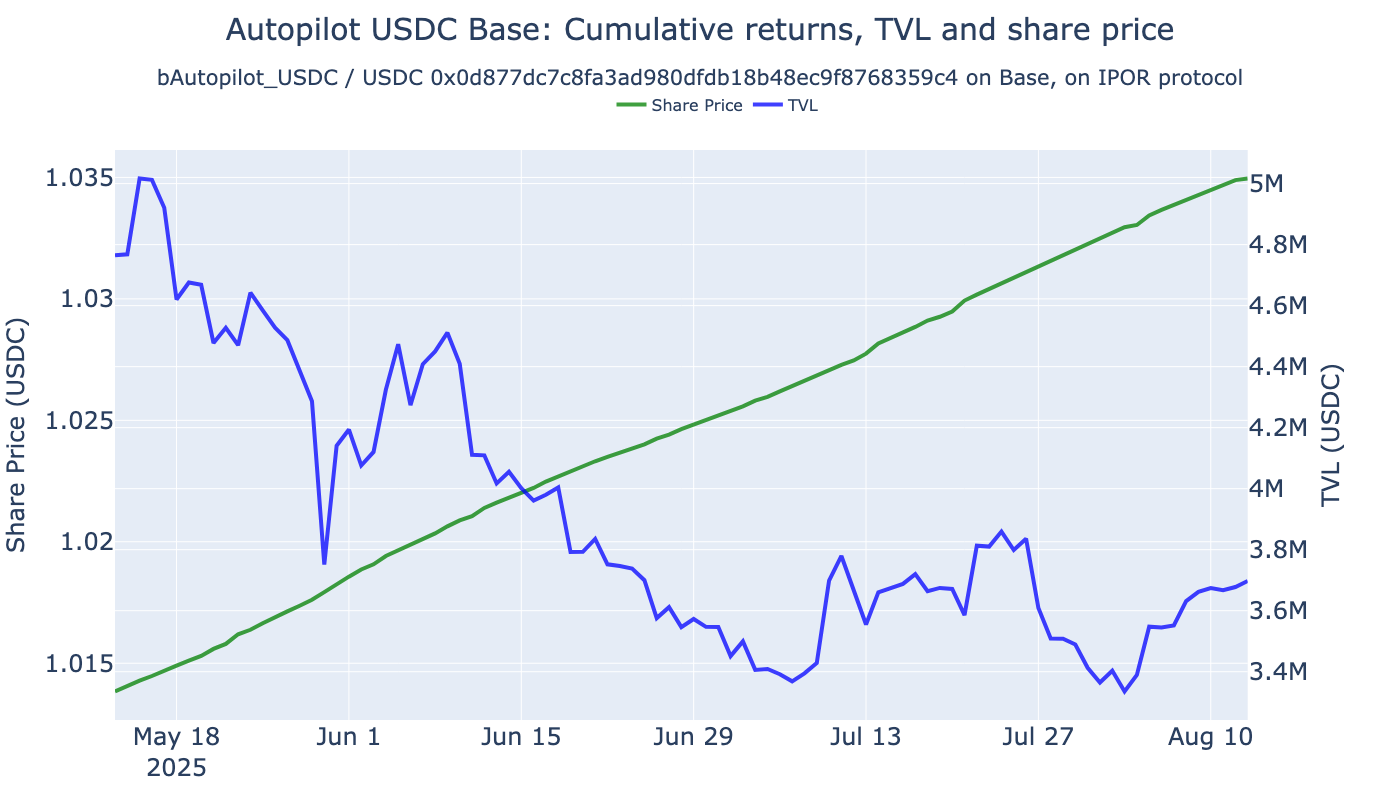

Vault               Autopilot USDC Base (Base)
Last price at              2025-08-13 06:02:57
Last price                                1.03
Block last price                    32,798,615
Month ago                  2025-07-13 06:02:57
Block month ago                     32,798,615
Month ago price                           1.03
Monthly change %                          0.72
dtype: object

Examining vault IPOR USDC Lending Optimizer Base: 8453-0x45aa96f0b3188d47a1dafdbefce1db6b37f58216, having 2,206 raw returns, 2,205 hourly and 92 daily returns
Share price movement: 1.0413 2025-05-13 06:02:57 -> 1.0584 2025-08-13 06:02:57


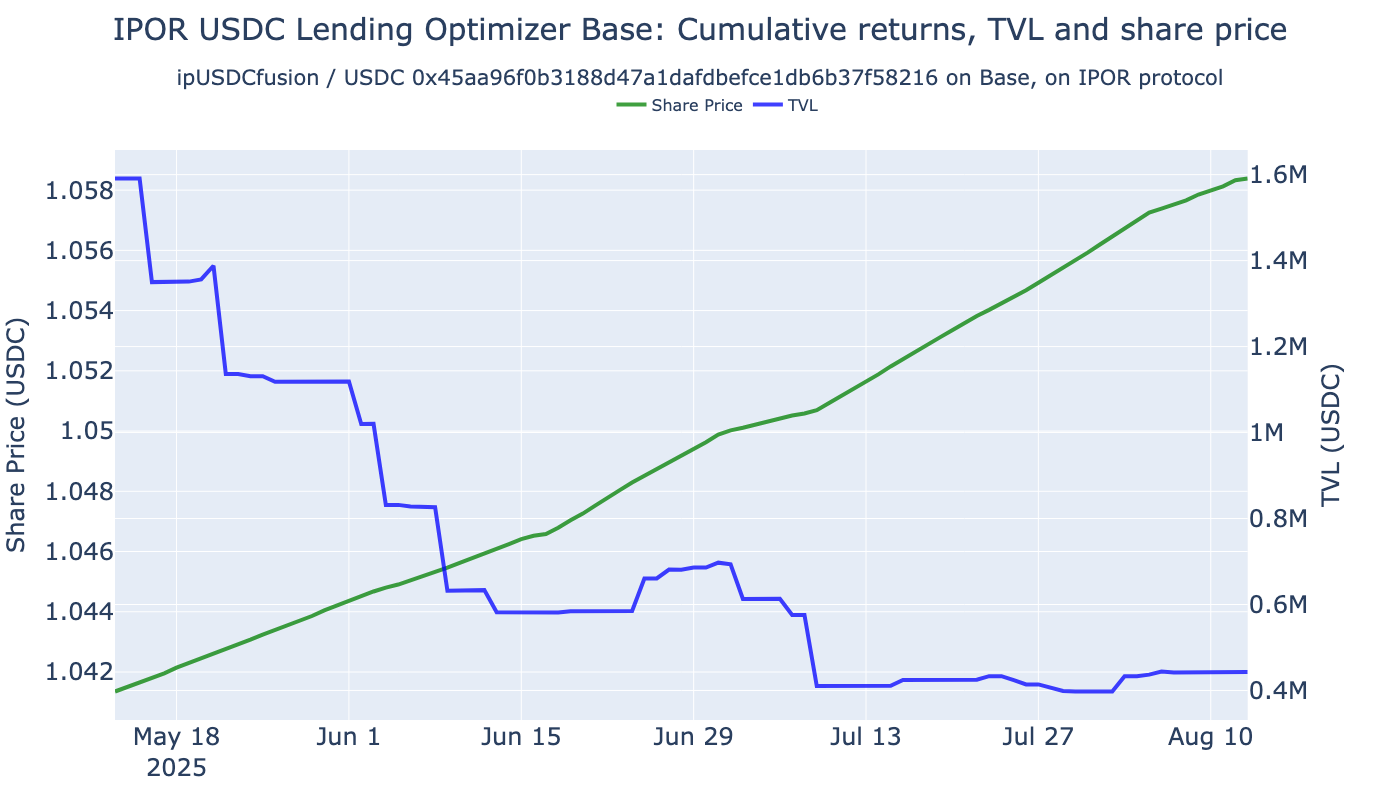

Vault               IPOR USDC Lending Optimizer Base (Base)
Last price at                           2025-08-13 06:02:57
Last price                                             1.06
Block last price                                 32,798,615
Month ago                               2025-07-13 06:02:57
Block month ago                                  32,798,615
Month ago price                                        1.05
Monthly change %                                       0.66
dtype: object

Examining vault Gains Network USDC: 137-0x29019fe2e72e8d4d2118e8d0318bef389ffe2c81, having 2,048 raw returns, 2,047 hourly and 92 daily returns
Share price movement: 1.1777 2025-05-13 06:42:57 -> 1.2083 2025-08-13 05:27:15


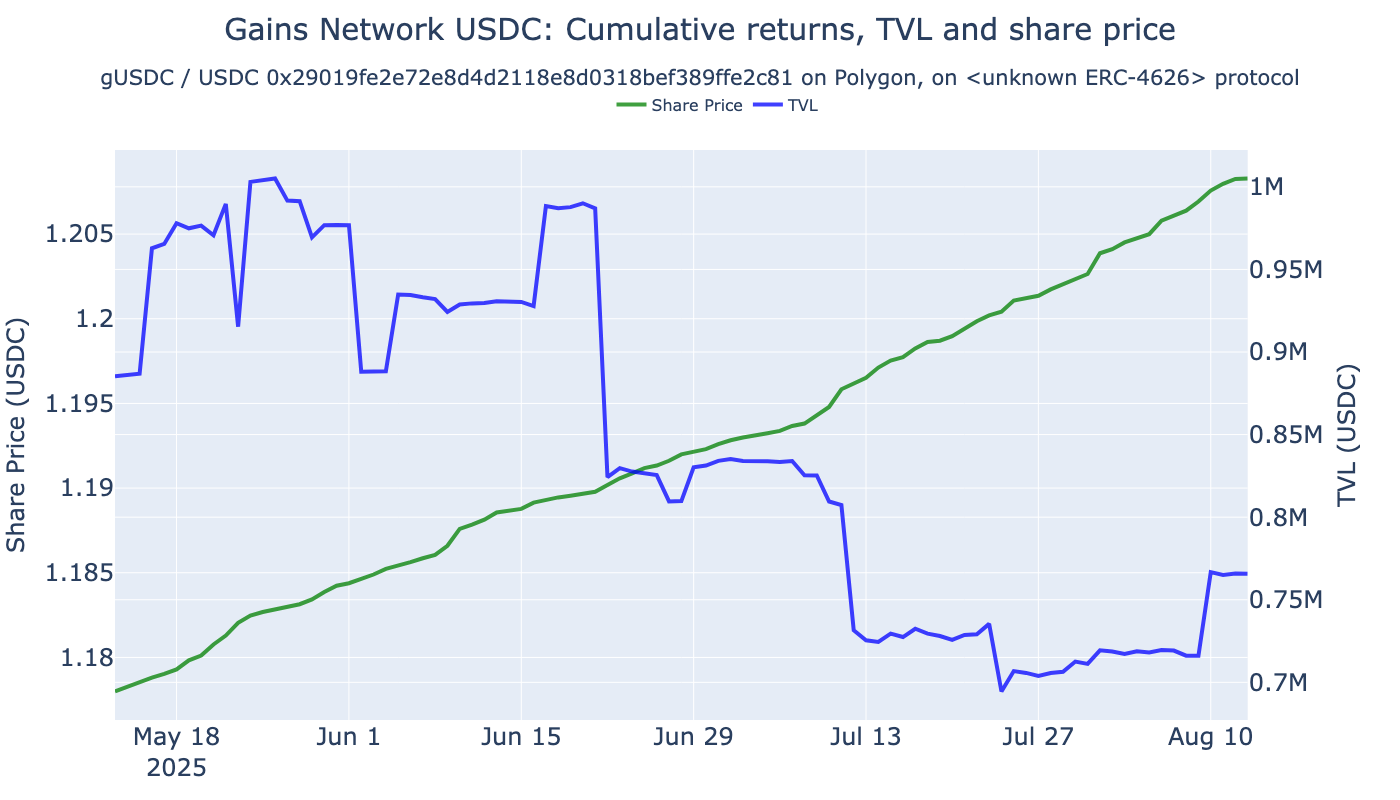

Vault               Gains Network USDC (Polygon)
Last price at                2025-08-13 05:27:15
Last price                                  1.21
Block last price                      73,900,334
Month ago                    2025-07-13 05:27:15
Block month ago                       73,900,334
Month ago price                             1.20
Monthly change %                            1.00
dtype: object

Examining vault Gains Network DAI: 42161-0xd85e038593d7a098614721eae955ec2022b9b91b, having 2,177 raw returns, 2,175 hourly and 92 daily returns
Share price movement: 1.2538 2025-05-13 06:48:01 -> 1.2695 2025-08-13 04:59:02


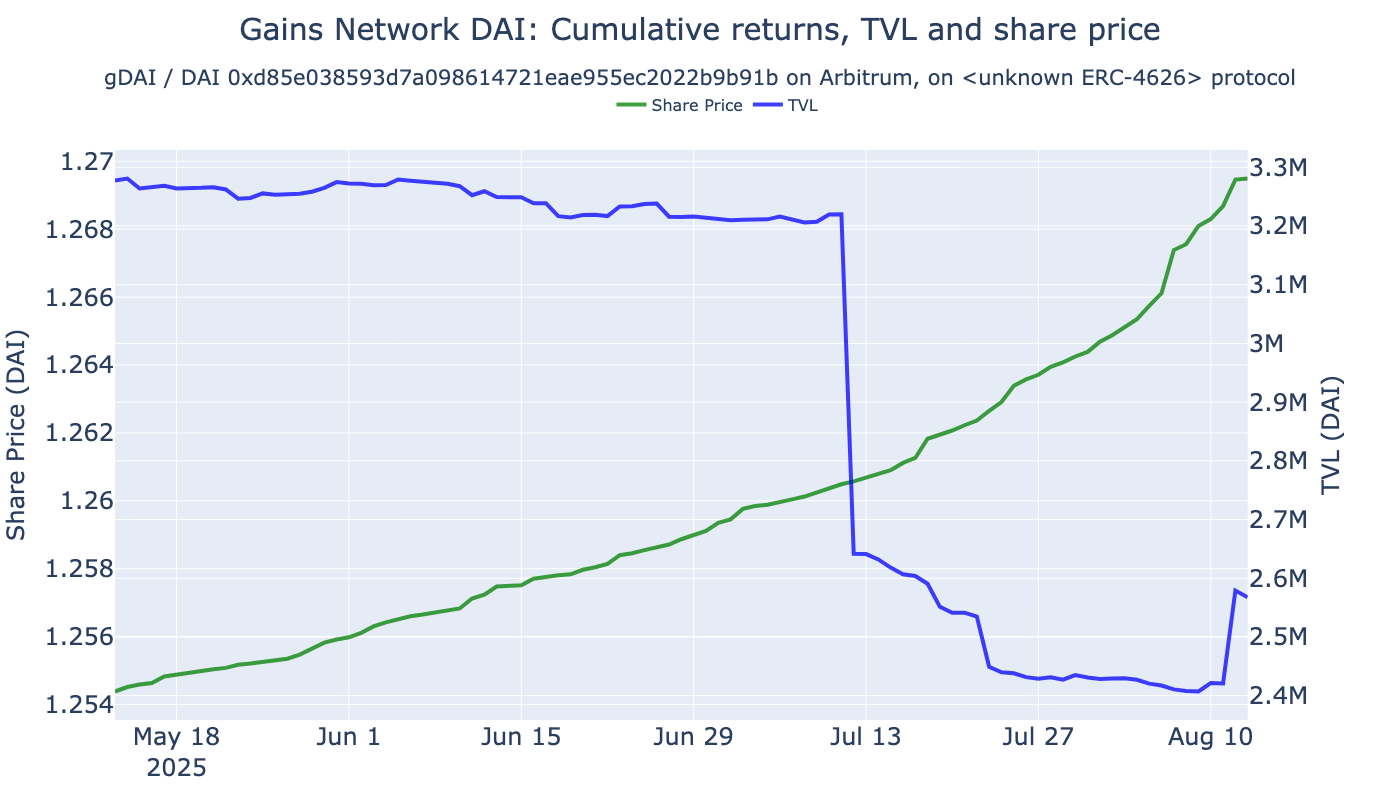

Vault               Gains Network DAI (Arbitrum)
Last price at                2025-08-13 04:59:02
Last price                                  1.27
Block last price                     357,152,321
Month ago                    2025-07-13 04:59:02
Block month ago                      357,152,321
Month ago price                             1.26
Monthly change %                            0.71
dtype: object

Examining vault Gains Network USDC: 42161-0xd3443ee1e91af28e5fb858fbd0d72a63ba8046e0, having 2,177 raw returns, 2,175 hourly and 92 daily returns
Share price movement: 1.1869 2025-05-13 06:48:01 -> 1.2172 2025-08-13 04:59:02


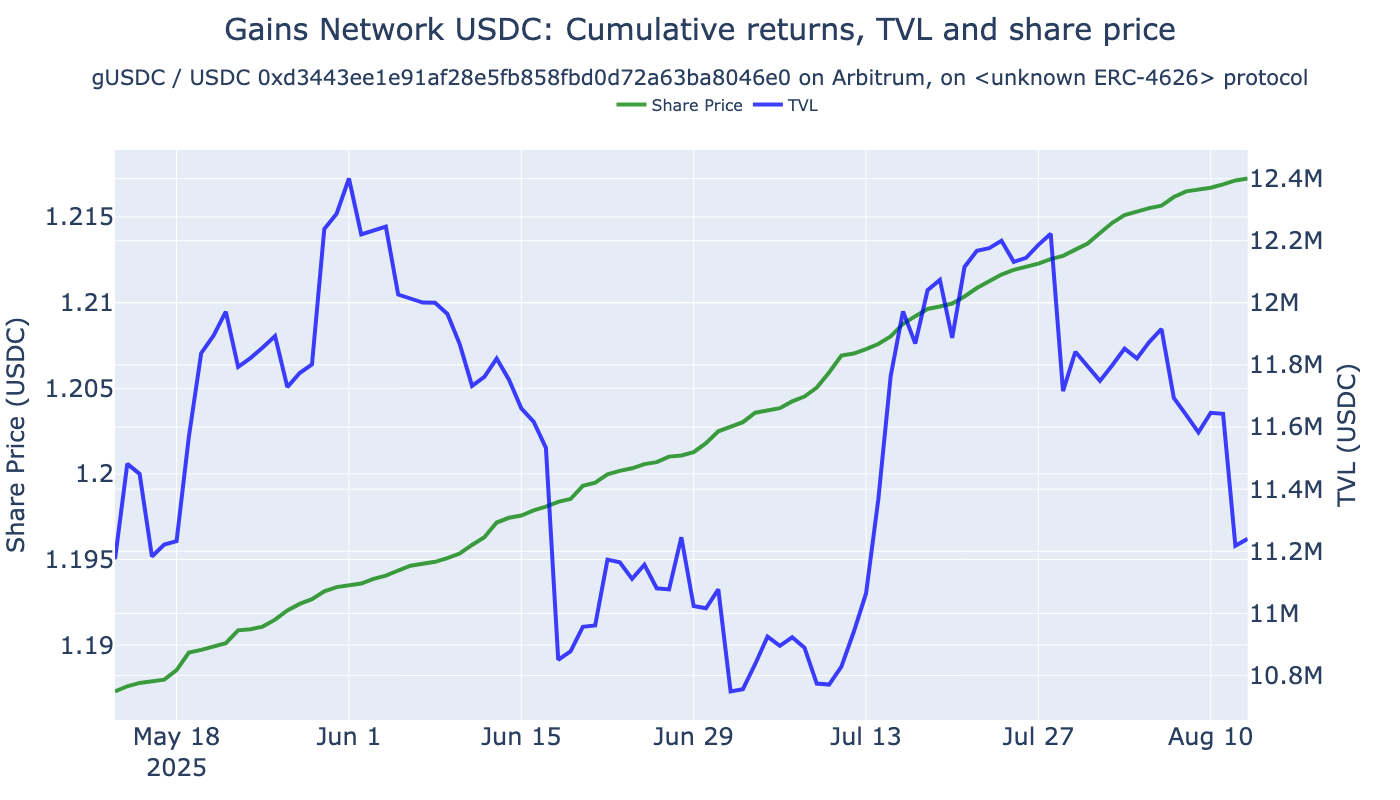

Vault               Gains Network USDC (Arbitrum)
Last price at                 2025-08-13 04:59:02
Last price                                   1.22
Block last price                      357,152,321
Month ago                     2025-07-13 04:59:02
Block month ago                       357,152,321
Month ago price                              1.21
Monthly change %                             0.84
dtype: object

Examining vault Peapods Interest Bearing USDC - 14: 42161-0xc2810eb57526df869049fbf4c541791a3255d24c, having 2,177 raw returns, 2,175 hourly and 92 daily returns
Share price movement: 1.1184 2025-05-13 06:48:01 -> 32.8462 2025-08-13 04:59:02


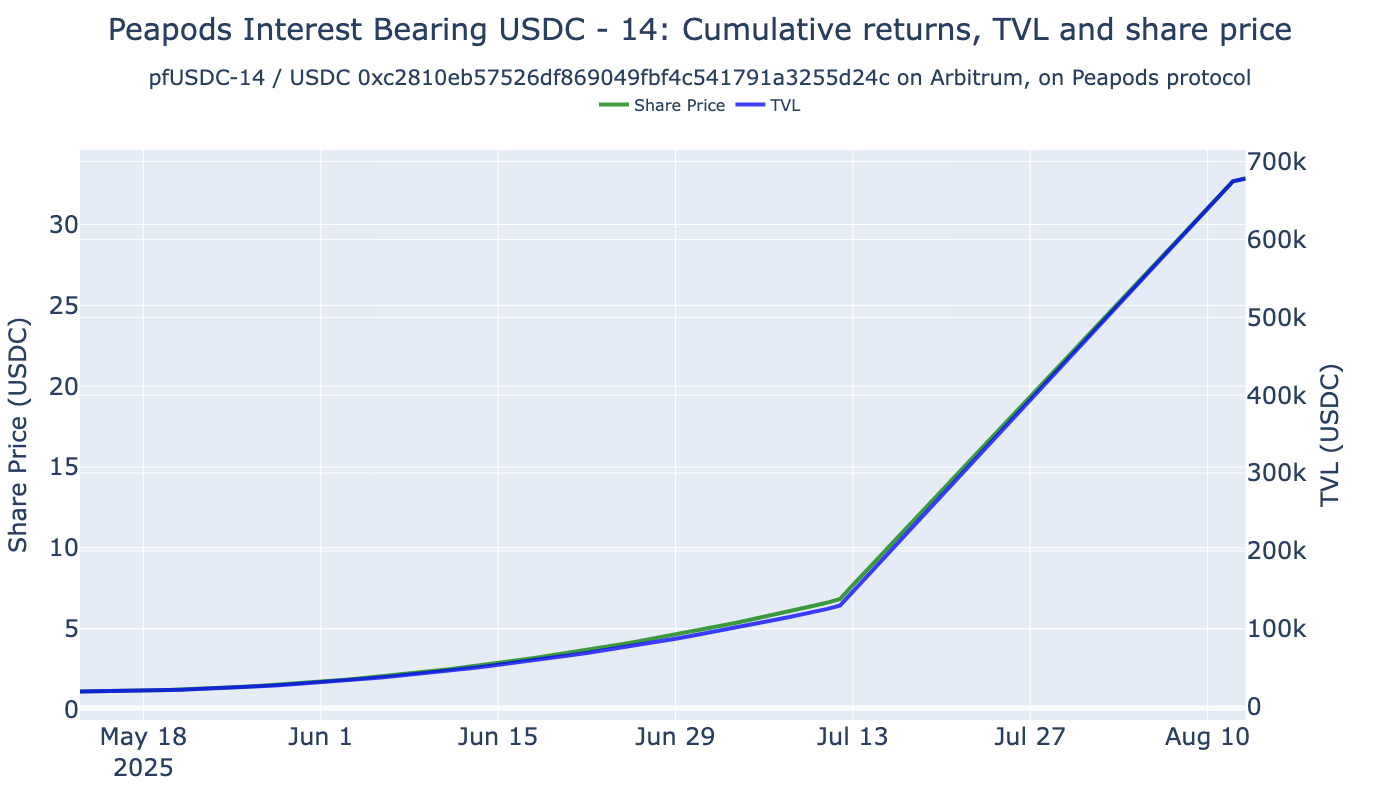

Vault               Peapods Interest Bearing USDC - 14 (Arbitrum)
Last price at                                 2025-08-13 04:59:02
Last price                                                  32.85
Block last price                                      357,152,321
Month ago                                     2025-07-13 04:59:02
Block month ago                                       357,152,321
Month ago price                                              6.99
Monthly change %                                           369.57
dtype: object

Examining vault Fluegel DAO: 8453-0x277a3c57f3236a7d4548576074d7c3d7046eb26c, having 2,206 raw returns, 2,205 hourly and 92 daily returns
Share price movement: 1.5750 2025-05-13 06:02:57 -> 1.9932 2025-08-13 06:02:57


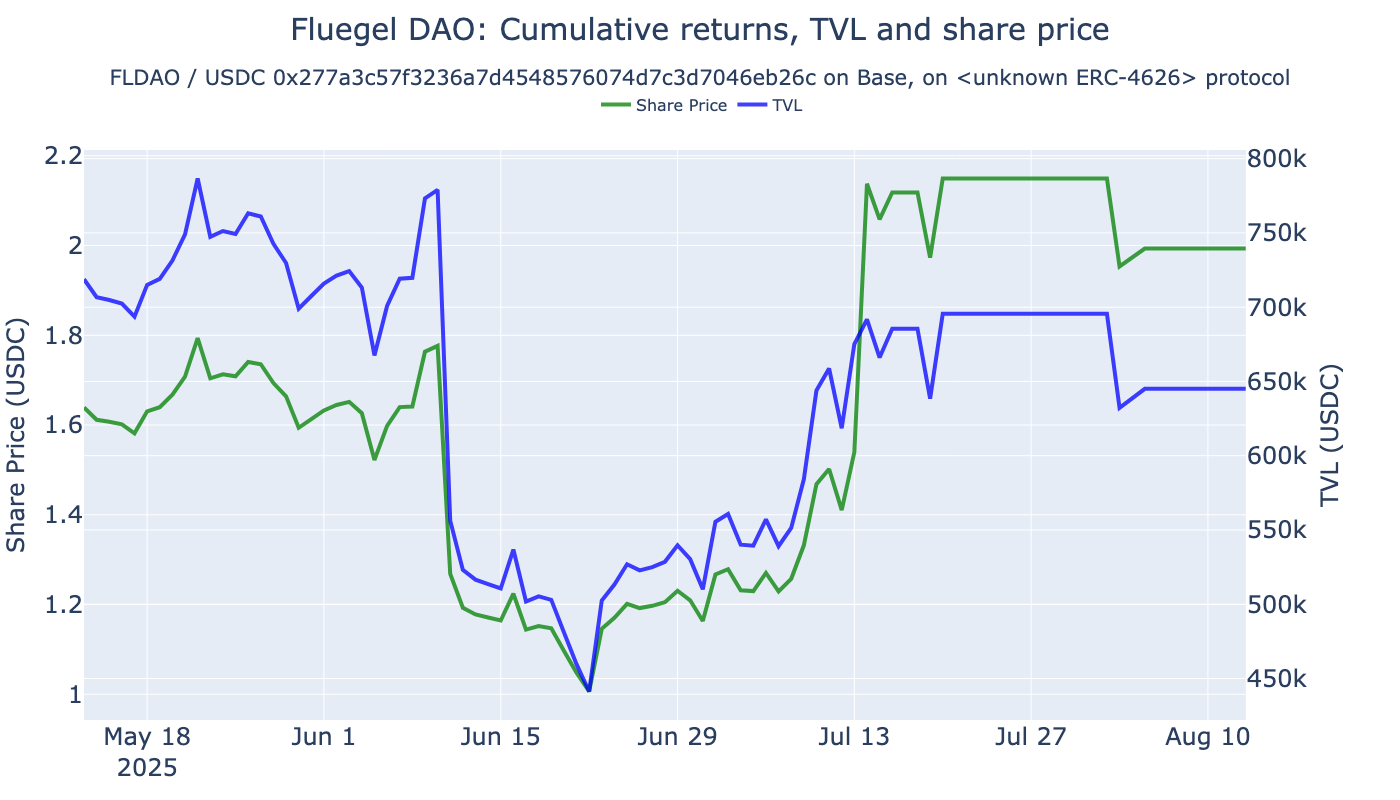

Vault                Fluegel DAO (Base)
Last price at       2025-08-13 06:02:57
Last price                         1.99
Block last price             32,798,615
Month ago           2025-07-13 06:02:57
Block month ago              32,798,615
Month ago price                    1.51
Monthly change %                  31.64
dtype: object

In [12]:
from eth_defi.research.vault_metrics import analyse_vault, format_ffn_performance_stats
from eth_defi.chain import get_chain_name

from tabulate import tabulate
from IPython.display import display, HTML

for vault_spec in VAULTS:
    vault_report = analyse_vault(
        vault_db=vault_db,
        prices_df=prices_df,
        spec=vault_spec,
        chart_frequency="daily",
    )

    chain_name = get_chain_name(vault_spec.chain_id)
    vault_name = vault_report.vault_metadata["Name"]
    display(HTML(f"<h2>Vault {vault_name} ({chain_name}): {vault_spec.vault_address})</h2><br>"))

    # Display returns figur
    returns_chart_fig = vault_report.rolling_returns_chart
    returns_chart_fig.show()

    # Check raw montly share price numbers for each vault
    hourly_price_df = vault_report.hourly_df
    last_price_at = hourly_price_df.index[-1]
    last_price = hourly_price_df["share_price"].asof(last_price_at)
    last_block = hourly_price_df["block_number"].asof(last_price_at)
    month_ago = last_price_at - pd.DateOffset(months=1)
    month_ago_price = hourly_price_df["share_price"].asof(month_ago)
    month_ago_block = hourly_price_df["block_number"].asof(month_ago)

    assert not pd.isna(month_ago_price), f"Vault {vault_spec.chain_id}-{vault_spec.vault_address}: no price data for month ago {month_ago} found, last price at {last_price_at} is {last_price}"

    data = {
        "Vault": f"{vault_name} ({chain_name})",
        "Last price at": last_price_at,
        "Last price": last_price,
        "Block last price": f"{month_ago_block:,}",
        "Month ago": month_ago,
        "Block month ago": f"{month_ago_block:,}",
        "Month ago price": month_ago_price,
        "Monthly change %": (last_price - month_ago_price) / month_ago_price * 100,
    }

    df = pd.Series(data)
    display(df)

    # Display FFN stats
    performance_stats = vault_report.performance_stats
    if performance_stats is not None:
        stats_df = format_ffn_performance_stats(performance_stats)
        # display(stats_df)
        display(HTML(stats_df.to_frame(name='Value').to_html(float_format='{:,.2f}'.format, index=True)))
    else:
        print(f"Vault {vault_spec.chain_id}-{vault_spec.vault_address}: performance metrics not available, is quantstats library installed?")

## Rolling returns comparison

- Show rolling returns of all picked vaults

id           timestamp  chain  \
0  137-0x29019fe2e72e8d4d2118e8d0318bef389ffe2c81 2025-05-13 06:42:57    137   
1  137-0x29019fe2e72e8d4d2118e8d0318bef389ffe2c81 2025-05-13 07:46:45    137   
2  137-0x29019fe2e72e8d4d2118e8d0318bef389ffe2c81 2025-05-13 08:50:30    137   

                                      address  block_number  share_price  \
0  0x29019fe2e72e8d4d2118e8d0318bef389ffe2c81      71455934         1.18   
1  0x29019fe2e72e8d4d2118e8d0318bef389ffe2c81      71457734         1.18   
2  0x29019fe2e72e8d4d2118e8d0318bef389ffe2c81      71459534         1.18   

   total_assets  total_supply  performance_fee  management_fee errors  \
0    883,546.04    487,856.47              NaN             NaN          
1    883,464.25    487,856.47              NaN             NaN          
2    883,404.36    487,856.47              NaN             NaN          

                                           name  event_count  \
0  Gains Network USDC (Polygon) #3401 (Polygon)          782   
1  Gains Network USDC (Polygon) #3401 (Polygon)          782   
2  Gains Network USDC (Polygon) #3401 (Polygon)          782   

             protocol  raw_share_price  pct_change_prev  pct_change_next  \
0  <unknown ERC-4626>             1.18             0.00             0.00   
1  <unknown ERC-4626>             1.18             0.00             0.00   
2  <unknown ERC-4626>             1.18             0.00             0.00   

   returns_1h  avg_assets_by_vault  dynamic_tvl_threshold  tvl_filtering_mask  \
0        0.00           644,579.52              12,891.59               False   
1        0.00           644,579.52              12,891.59               False   
2        0.00           644,579.52              12,891.59               False   

   rolling_1m_returns  
0                0.00  
1                0.00  
2                0.00

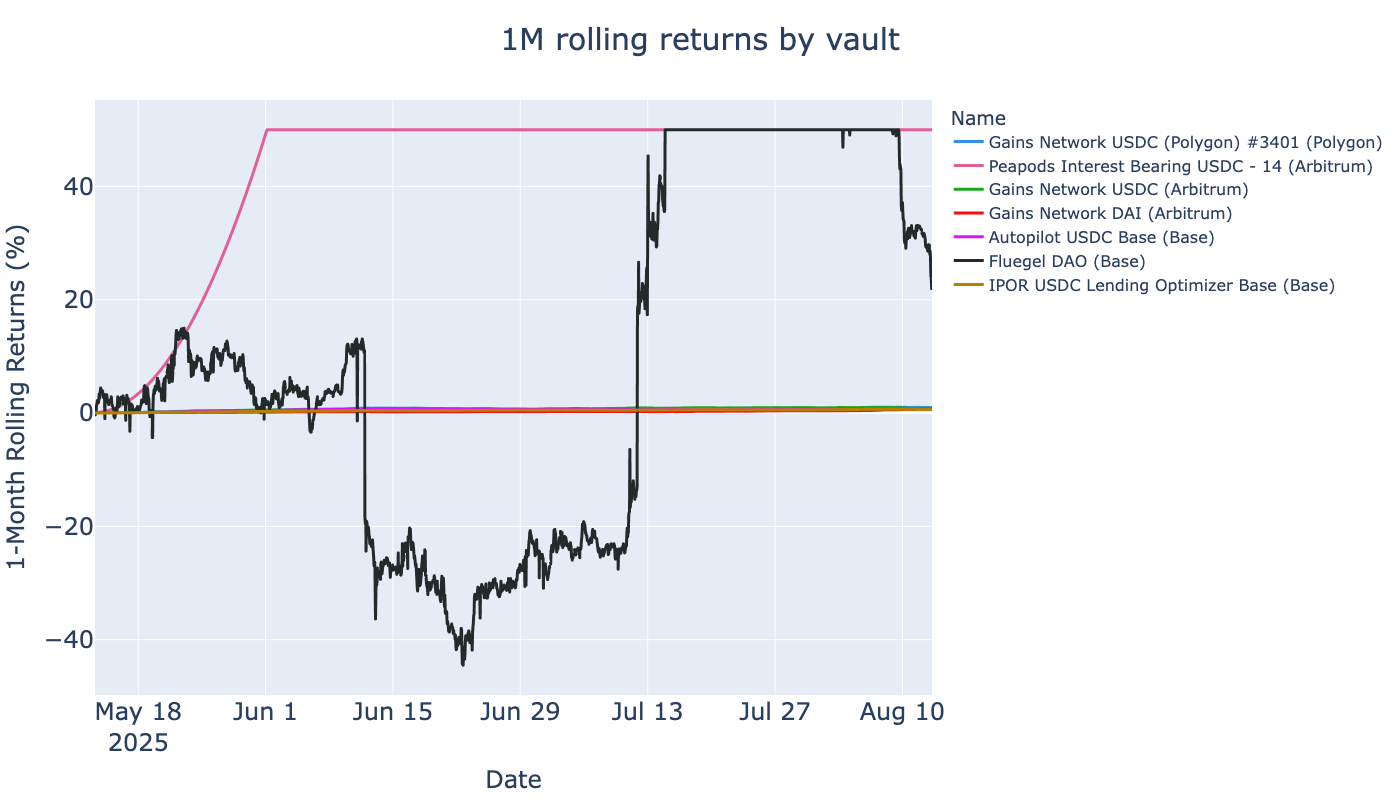

In [13]:
from eth_defi.research.rolling_returns import calculate_rolling_returns, visualise_rolling_returns

interesting_vaults = [spec.as_string_id() for spec in VAULTS]

rolling_returns_df = calculate_rolling_returns(
    prices_df,
    interesting_vaults=interesting_vaults,
    clip_up=50,
)

display(rolling_returns_df.head(3))

fig = visualise_rolling_returns(rolling_returns_df)

fig.show()

## Raw vault data

- Examine raw data of a single vault
- Find abnormal return rows

In [14]:
# Fluegel DAO
# 8453-0x277a3c57f3236a7d4548576074d7c3d7046eb26c
# https://fluegelcoin.com/dashboard
vault_spec = VaultSpec(8453, "0x277a3c57f3236a7d4548576074d7c3d7046eb26c")

df = prices_df[prices_df["id"] == vault_spec.as_string_id()]

# 10% claimed hourly returns
mask = df["returns_1h"].abs() > 0.10
expanded_mask = (mask | mask.shift(1) | mask.shift(-1)).fillna(False)

df = df[expanded_mask]  # Filter out rows with small returns

display(df.head(10))

chain                                     address  \
timestamp                                                                
2025-06-11 01:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2025-06-11 02:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2025-06-11 03:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2025-06-11 04:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2025-06-11 21:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2025-06-11 22:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2025-06-11 23:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2025-07-14 21:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2025-07-14 22:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2025-07-14 23:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   

                     block_number  share_price  total_assets  total_supply  \
timestamp                                                                    
2025-06-11 01:02:57      31407215         1.77    777,746.18    438,558.97   
2025-06-11 02:02:57      31409015         1.55    681,142.20    438,558.97   
2025-06-11 03:02:57      31410815         1.76    773,557.02    438,558.97   
2025-06-11 04:02:57      31412615         1.77    774,341.08    438,558.97   
2025-06-11 21:02:57      31443215         1.75    766,806.70    438,558.97   
2025-06-11 22:02:57      31445015         1.29    564,821.81    438,558.97   
2025-06-11 23:02:57      31446815         1.27    556,150.40    438,558.97   
2025-07-14 21:02:57      32868815         1.58    692,520.49    438,558.97   
2025-07-14 22:02:57      32870615         2.13    690,103.14    323,616.44   
2025-07-14 23:02:57      32872415         2.14    691,767.47    323,616.44   

                     performance_fee  management_fee errors  \
timestamp                                                     
2025-06-11 01:02:57              NaN             NaN          
2025-06-11 02:02:57              NaN             NaN          
2025-06-11 03:02:57              NaN             NaN          
2025-06-11 04:02:57              NaN             NaN          
2025-06-11 21:02:57              NaN             NaN          
2025-06-11 22:02:57              NaN             NaN          
2025-06-11 23:02:57              NaN             NaN          
2025-07-14 21:02:57              NaN             NaN          
2025-07-14 22:02:57              NaN             NaN          
2025-07-14 23:02:57              NaN             NaN          

                                                                  id  \
timestamp                                                              
2025-06-11 01:02:57  8453-0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2025-06-11 02:02:57  8453-0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2025-06-11 03:02:57  8453-0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2025-06-11 04:02:57  8453-0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2025-06-11 21:02:57  8453-0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2025-06-11 22:02:57  8453-0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2025-06-11 23:02:57  8453-0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2025-07-14 21:02:57  8453-0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2025-07-14 22:02:57  8453-0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2025-07-14 23:02:57  8453-0x277a3c57f3236a7d4548576074d7c3d7046eb26c   

                            name  event_count            protocol  \
timestamp                                                           
2025-06-11 01:02:57  Fluegel DAO          185  <unknown ERC-4626>   
2025-06-11 02:02:57  Fluegel DAO          185  <unknown ERC-4626>   
2025-06-11 03:02:57  Fluegel DAO          185  <unknown ERC-4626>   
2025-06-11 04:02:57  Fluegel DAO          185  <unknown ERC-4626>   
2025-06-11 21:02:57  Fluegel DAO          185  <unknown ERC-4626>   
2025-06-11 22:02:57  Fluegel DAO          185  <unknown ERC-4626>   
2025-06-11 23:02:57  